In [2]:
"""
    Author: Alex Nguyen
    Gettysburg College class of 2022
    This file get into the analysis of sound processing and some of its application

    Note: I have written every single lines
    The documentation will be written as the file goes along.

"""

'\n    Author: Alex Nguyen\n    Gettysburg College class of 2022\n    This file get into the analysis of sound processing and some of its application\n\n    Note: I have written every single lines\n    The documentation will be written as the file goes along.\n\n'

In [3]:

class Config:
    def __init__(self, var, x):
        self.var = var
        self.x = x


In [4]:

#--------------------------------- Importing library ---------------------------------#

# OS, IO
from scipy.io import wavfile
import os, sys, shutil

# Sound Processing library
import librosa
from pydub import AudioSegment

# Math Library
import numpy as np

# Display library
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
plt.interactive(True)
import librosa.display

# Data Preprocessing
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
import sklearn

# Deep Learning Library
from keras.models import Model, Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, LSTM, Bidirectional, GRU
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.optimizers import Adam, SGD
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.utils import Sequence
from keras.optimizers import Adam, SGD, RMSprop


In [5]:

# Dataset and classes definition

base_dir = 'dataset/genres_converted'

classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'raggae', 'rock']


In [6]:

# Dataset Separation

val_base_dir = './dataset/genres_converted_val'

for id, folder in enumerate(os.listdir(base_dir)):
    idx = 0
    list_val = os.listdir(val_base_dir)
    if folder not in list_val:
        os.mkdir(os.path.join(val_base_dir, folder))
    for _, fname in enumerate(os.listdir(os.path.join(base_dir, folder))):
        if fname.endswith('.wav') and idx % 10 == 0:
            # shutil.copy2(os.path.join(base_dir, folder, fname), os.path.join(val_base_dir, folder))
            shutil.move(os.path.join(base_dir, folder, fname), os.path.join(val_base_dir, folder))
        idx += 1


In [7]:

""" Data Preprocessor class """

class DataPreprocessor:

    """
    Converting labels to integers
    :param labels: (1D np array) An array of associated labels with data
    :return: (1D np array) An array of integer representing the associated labels
    """
    @staticmethod
    def tokenize(labels):
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(labels)
        label_matrix = np.asarray(tokenizer.texts_to_sequences(labels))
        y = np.reshape(label_matrix, label_matrix.shape[0])
        return y, tokenizer
    
    @staticmethod
    def generate_label(classes):
        label_matrix, tokenizer = DataPreprocessor.tokenize(classes)
        return to_categorical(label_matrix), tokenizer

    """
    :param fname:
    :param window_size: (Integer) the max length of axis 1 of x.
    """
    @staticmethod
    def get_spect(fname):
        y, sr = librosa.core.load(fname)
        spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=512)
        spect = librosa.power_to_db(spect, ref=np.max)
        # Normalization
        # for i, feature in enumerate(spect):
        #     max_val = feature.max(axis=0)
        #     min_val = feature.min(axis=0)
        #     diff = max_val - min_val
        #     for j, time in enumerate(feature):
        #         spect[i][j] = (time - min_val) / diff
        return spect

    @staticmethod
    def get_mfcc(fname, n_mfcc=40):
        y, sr = librosa.core.load(fname)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        """ Feature Scaling MFCC """
        mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
        return mfccs

    @staticmethod
    def pad_matrix(matrix, max_length):
        return np.concatenate((matrix, np.zeros(shape=(matrix.shape[0], max_length - matrix.shape[1]))), axis=1)


In [8]:

""" Data Generator Class """

class AudioDataGenerator(Sequence):
    """
    :param data_path: (String) This is the base folder data.
    :param batch_size: (int32) This is the base folder data.
    :param dim: (Tuple: (a, b, c)) 3D tuple shape of input dimension
    :param n_channels: (int32) Number of channel.
    :param n_classes: (int32) Number of classes.
    :param shuffle: (boolean) Specify whether or not you want to shuffle the data to be trained.
    """
    def __init__(self, data_path, batch_size=32, dim=(128,1308), n_channels=1,
             n_classes=10, shuffle=True):
        """
        :var self.classes:
        :var self.labels:
        :var self.fname:
        :var self.data:
        :var self.dim:
        :var self.batch_size:
        :var self.list_IDs:
        :var self.n_channels:
        :var self.n_classes:
        :var self.shuffle:
        :var self.tokenizer:
        :var self.data_path:
        """
        self.classes = []
        self.labels = []
        self.fname = []
        self.data = []

        self.data_size = 0
        self.data_shape = (None,None)
        self.data_path = data_path
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = []
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.load_data()
        
    """
    :param data_path: (String) The actual base folder of data
    """
    def load_data(self):

        # Generate labels and convert to categorized 2D-vector
        for i, _cls in enumerate(os.listdir(self.data_path)):
            self.classes.append(_cls)
            for j, fname in enumerate(os.listdir(os.path.join(self.data_path, _cls))):
                self.fname.append(os.path.join(base_dir, _cls, fname))
                self.labels.append(_cls)
                
        print("Found {} classes in root data folder".format(len(self.classes)))
        self.labels, self.tokenizer = DataPreprocessor.generate_label(self.labels)
        self.labels = np.asarray(self.labels)
        self.data_size = self.labels.shape[0]
            
    
    def build_data_stft(self):
        print('Building data...')

        temp_data = []
        max_length = 0
        for i, fname in enumerate(self.fname):
            spect = DataPreprocessor.get_spect(fname)
            temp_data.append(spect)
            if spect.shape[1] > max_length:
                max_length = spect.shape[1]

        self.data = np.zeros(shape=(self.data_size, self.dim[0], max_length))

        for i, spect in enumerate(temp_data):
            if spect.shape[1] < max_length:
                self.data[i] = DataPreprocessor.pad_matrix(spect, max_length)
            else:
                self.data[i] = spect

        self.data = np.expand_dims(self.data, axis=3)

        print('Build Data Successful!')
        print('Found {} pieces of data and converted each piece in to shape {}'.format(self.data_size, self.dim[1:]))


        # datums = []
        # for i, fname in enumerate(self.fname):
        #     datums.append(DataPreprocessor.get_spect(fname))

        # max_length = 0
        # for i, datum in enumerate(datums):
        #     if datum.shape[1] > max_length:
        #         max_length = datum.shape[1]

        # self.data = np.zeros(shape=(self.data_size, self.dim[0], max_length))
        # for i, datum in enumerate(datums):
        #     if max_length > datum.shape[1]:
        #         datum = np.concatenate((datum, np.zeros(shape=(datum.shape[0], max_length - datum.shape[1]))), axis=1)
        #     self.data[i] = datum
            
        # print('Build Data Successful!')
        # print('Found {} pieces of data and converted each piece in to shape {}'.format(self.data_size, max_length))

    def build_data_mfcc(self):
        for fname in self.fname:
            datum = DataPreprocessor.get_mfcc(fname)
        return

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        return

    def __len__(self):
        return

    def __getitem__(self, index):
        return


In [9]:

""" Data Generator Class """

class AudioDataGenerator2D(Sequence):
    """
    :param data_path: (String) This is the base folder data.
    :param batch_size: (int32) This is the base folder data.
    :param dim: (Tuple: (a, b, c)) 3D tuple shape of input dimension
    :param n_channels: (int32) Number of channel.
    :param n_classes: (int32) Number of classes.
    :param shuffle: (boolean) Specify whether or not you want to shuffle the data to be trained.
    """
    def __init__(self, data_path, batch_size=32, dim=(128,1308), n_channels=1,
             n_classes=10, shuffle=True, validation_split=0.1):
        """
        :var self.classes:
        :var self.labels:
        :var self.fname:
        :var self.data:
        :var self.dim:
        :var self.batch_size:
        :var self.list_IDs:
        :var self.n_channels:
        :var self.n_classes:
        :var self.shuffle:
        :var self.tokenizer:
        :var self.data_path:
        """
        self.classes = []
        self.labels = []
        self.fname = []
        self.data = []
        self.data_validation = []

        self.validation_split = validation_split
        self.data_size = 0
        self.data_shape = (None,None)
        self.data_path = data_path
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = []
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.load_data()
        
    """
    :param data_path: (String) The actual base folder of data
    """
    def load_data(self):

        # Generate labels and convert to categorized 2D-vector
        for i, _cls in enumerate(os.listdir(self.data_path)):
            self.classes.append(_cls)
            for j, fname in enumerate(os.listdir(os.path.join(self.data_path, _cls))):
                self.fname.append(os.path.join(self.data_path, _cls, fname))
                self.labels.append(_cls)
                
        print("Found {} classes in root data folder".format(len(self.classes)))
        self.labels, self.tokenizer = DataPreprocessor.generate_label(self.labels)
        self.labels = np.asarray(self.labels)
        self.data_size = self.labels.shape[0]
            
    
    def build_data_stft(self):
        print('Building data...')

        temp_data = []
        max_length = 0
        for i, fname in enumerate(self.fname):
            spect = DataPreprocessor.get_spect(fname)
            temp_data.append(spect)
            if spect.shape[1] > max_length:
                max_length = spect.shape[1]

        self.data = np.zeros(shape=(self.data_size, self.dim[0], max_length))

        for i, spect in enumerate(temp_data):
            if spect.shape[1] < max_length:
                self.data[i] = DataPreprocessor.pad_matrix(spect, max_length)
            else:
                self.data[i] = spect

        self.data = np.expand_dims(self.data, axis=3)

        # datums = []
        # for i, fname in enumerate(self.fname):
        #     datums.append(DataPreprocessor.get_spect(fname))

        # max_length = 0
        # for i, datum in enumerate(datums):
        #     if datum.shape[1] > max_length:
        #         max_length = datum.shape[1]

        # self.data = np.zeros(shape=(self.data_size, self.dim[0], max_length))
        # for i, datum in enumerate(datums):
        #     if max_length > datum.shape[1]:
        #         datum = np.concatenate((datum, np.zeros(shape=(datum.shape[0], max_length - datum.shape[1]))), axis=1)
        #     self.data[i] = datum
            
        # print('Build Data Successful!')
        # print('Found {} pieces of data and converted each piece in to shape {}'.format(self.data_size, max_length))

        print('Build Data Successful!')
        print('Found {} pieces of data and converted each piece in to shape {}'.format(self.data_size, self.dim[1:]))

    def build_data_mfcc(self):
        for fname in self.fname:
            datum = DataPreprocessor.get_mfcc(fname)
        return

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        return

    def __len__(self):
        return

    def __getitem__(self, index):
        return



In [10]:

""" Build Datagenerator """

dataGen = AudioDataGenerator2D(base_dir)


Found 10 classes in root data folder


In [11]:

dataGen.build_data_stft()


Building data...
Build Data Successful!
Found 810 pieces of data and converted each piece in to shape (1308,)


In [12]:

""" Data Validation Generator Class """

class AudioValidationDataGenerator2D(Sequence):
    """
    :param data_path: (String) This is the base folder data.
    :param batch_size: (int32) This is the base folder data.
    :param dim: (Tuple: (a, b, c)) 3D tuple shape of input dimension
    :param n_channels: (int32) Number of channel.
    :param n_classes: (int32) Number of classes.
    :param shuffle: (boolean) Specify whether or not you want to shuffle the data to be trained.
    """
    def __init__(self, data_path, batch_size=32, dim=(128,1308), n_channels=1,
             n_classes=10, shuffle=True, validation_split=0.1):
        """
        :var self.classes:
        :var self.labels:
        :var self.fname:
        :var self.data:
        :var self.dim:
        :var self.batch_size:
        :var self.list_IDs:
        :var self.n_channels:
        :var self.n_classes:
        :var self.shuffle:
        :var self.tokenizer:
        :var self.data_path:
        """
        self.classes = []
        self.labels = []
        self.fname = []
        self.data = []
        self.data_validation = []

        self.validation_split = validation_split
        self.data_size = 0
        self.data_shape = (None,None)
        self.data_path = data_path
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = []
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.load_data()
        
    """
    :param data_path: (String) The actual base folder of data
    """
    def load_data(self):

        # Generate labels and convert to categorized 2D-vector
        for i, _cls in enumerate(os.listdir(self.data_path)):
            self.classes.append(_cls)
            for j, fname in enumerate(os.listdir(os.path.join(self.data_path, _cls))):
                self.fname.append(os.path.join(self.data_path, _cls, fname))
                self.labels.append(_cls)
                
        print("Found {} classes in root data folder".format(len(self.classes)))
        self.labels, self.tokenizer = DataPreprocessor.generate_label(self.labels)
        self.labels = np.asarray(self.labels)
        self.data_size = self.labels.shape[0]
            
    
    def build_data_stft(self):
        print('Building data...')

        temp_data = []
        max_length = 0
        for i, fname in enumerate(self.fname):
            spect = DataPreprocessor.get_spect(fname)
            temp_data.append(spect)
            if spect.shape[1] > max_length:
                max_length = spect.shape[1]

        self.data = np.zeros(shape=(self.data_size, self.dim[0], max_length))

        for i, spect in enumerate(temp_data):
            if spect.shape[1] < max_length:
                self.data[i] = DataPreprocessor.pad_matrix(spect, max_length)
            else:
                self.data[i] = spect

        self.data = np.expand_dims(self.data, axis=3)

        print('Build Data Successful!')
        print('Found {} pieces of data and converted each piece in to shape {}'.format(self.data_size, self.dim[1:]))

    def build_data_mfcc(self):
        for fname in self.fname:
            datum = DataPreprocessor.get_mfcc(fname)
        return



In [13]:

val_dataGen = AudioValidationDataGenerator2D(val_base_dir)


Found 10 classes in root data folder


In [14]:

val_dataGen.build_data_stft()


Building data...
Build Data Successful!
Found 190 pieces of data and converted each piece in to shape (1308,)


In [15]:

val_dataGen.data[0].shape


(128, 1320, 1)

In [16]:

""" Considering mel spectrogram of different kind of music """

ftest1 = 'dataset/genres_converted/classical/classical.00000.wav'
ftest2 = 'dataset/genres_converted/blues/blues.00000.wav'
ftest3 = 'dataset/genres_converted/hiphop/hiphop.00000.wav'
ftest4 = 'dataset/genres_converted/jazz/jazz.00000.wav'
ftest5 = 'dataset/genres_converted/metal/metal.00000.wav'



f1 = DataPreprocessor.get_spect(ftest1)
f2 = DataPreprocessor.get_spect(ftest2)
f3 = DataPreprocessor.get_spect(ftest3)
f4 = DataPreprocessor.get_spect(ftest4)
f5 = DataPreprocessor.get_spect(ftest5)

plt.figure(figsize=(7,3))
librosa.display.specshow(f1, sr=22050, x_axis='time', y_axis='hz')

plt.figure(figsize=(7,3))
librosa.display.specshow(f2, sr=22050, x_axis='time', y_axis='hz')

plt.figure(figsize=(7,3))
librosa.display.specshow(f3, sr=22050, x_axis='time', y_axis='hz')

plt.figure(figsize=(7,3))
librosa.display.specshow(f4, sr=22050, x_axis='time', y_axis='hz')

plt.figure(figsize=(7,3))
librosa.display.specshow(f5, sr=22050, x_axis='time', y_axis='hz')

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/genres_converted/classical/classical.00000.wav'

In [17]:

""" Model Class """

class TrainingModels:
    
    def buildModel1(shape=(None, 128, 1320)):
        in_tensor = Input(shape=(None, None))
        tensor = Conv1D(512, kernel_size=(3,), activation='relu') (in_tensor)
        tensor = MaxPool1D(264)(tensor)
        tensor = Conv1D(256, kernel_size=(3,), activation='relu') (tensor)
        tensor = MaxPool1D(128)(tensor)
        tensor = Conv1D(64, kernel_size=(3,), activation='relu') (tensor)
        tensor = MaxPool1D(32)(tensor)

        tensor = Flatten() (tensor)

        tensor = Dense(16, activation='relu')(tensor)
        tensor = Dense(1, activation='sigmoid') (tensor)

        model = Model (in_tensor, tensor)

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        return model


In [18]:

# Train model

def buildModel1(shape=(128, 1320)):
    in_tensor = Input(shape=shape)
    tensor = Conv1D(512, kernel_size=(3,), activation='relu') (in_tensor)
    tensor = MaxPooling1D(2)(tensor)
    

    tensor = Flatten() (tensor)

    tensor = Dense(16, activation='relu')(tensor)
    tensor = Dense(11, activation='sigmoid') (tensor)

    model = Model (in_tensor, tensor)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model



In [19]:

def build_model_2D(shape):
    in_tensor = Input(shape=shape)

    # 2D Convolution Layer 1
    tensor = Conv2D(256, kernel_size=(3,3), data_format="channels_last", activation='relu', padding='valid')(in_tensor)
    tensor = MaxPooling2D(2)(tensor)

    # 2D Convolution Layer 2
    tensor = Conv2D(128, kernel_size=(3,3), data_format="channels_last", activation='relu', padding='valid')(tensor)
    tensor = MaxPooling2D(2)(tensor)

    # 2D Convolution Layer 3
    tensor = Conv2D(64, kernel_size=(3,3), data_format="channels_last", activation='relu', padding='valid')(tensor)
    tensor = MaxPooling2D(2)(tensor)

    # Flatten
    tensor = Flatten()(tensor)

    # Dense
    tensor = Dense(32, activation='relu')(tensor)
    tensor = Dense(16, activation='relu')(tensor)
    tensor = Dense(11, activation='sigmoid')(tensor)

    # Compile
    model = Model(in_tensor, tensor)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [20]:


def build_model_2D_2(shape):
    in_tensor = Input(shape=shape)

    # 2D Convolution Layer 1
    tensor = Conv2D(128, kernel_size=(3,3), data_format="channels_last", activation='elu', padding='valid')(in_tensor)
    tensor = MaxPooling2D(2)(tensor)

    # 2D Convolution Layer 2
    tensor = Conv2D(64, kernel_size=(3,3), data_format="channels_last", activation='elu', padding='valid')(tensor)
    tensor = MaxPooling2D(2)(tensor)

    # 2D Convolution Layer 3
    tensor = Conv2D(32, kernel_size=(3,3), data_format="channels_last", activation='elu', padding='valid')(tensor)
    tensor = MaxPooling2D(2)(tensor)

    # 2D Convolution Layer 4
    tensor = Conv2D(16, kernel_size=(3,3), data_format="channels_last", activation='elu', padding='valid')(tensor)
    tensor = MaxPooling2D(2)(tensor)

    # Flatten
    tensor = Flatten()(tensor)
    
    # Dense
    tensor = Dense(512, activation='elu')(tensor)
    tensor = Dropout(0.5)(tensor)
    tensor = Dense(16, activation='elu')(tensor)
    tensor = Dense(11, activation='softmax')(tensor)

    # Compile
    model = Model(in_tensor, tensor)
    rmsOp = RMSprop(lr=0.000001)
    model.compile(optimizer=rmsOp, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [21]:

model = build_model_2D_2(shape=dataGen.data.shape[1:])
model.summary()


W1003 14:46:25.781733 12916 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1003 14:46:25.814594 12916 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1003 14:46:25.820563 12916 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1003 14:46:25.838484 12916 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1003 14:46:25.884361 12916 deprecation_wrapper.py:119] From C:\ProgramData\Ana

In [22]:

model = buildModel1()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 1320)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 126, 512)          2028032   
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 63, 512)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32256)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                516112    
_________________________________________________________________
dense_5 (Dense)              (None, 11)                187       
Total params: 2,544,331
Trainable params: 2,544,331
Non-trainable params: 0
_________________________________________________________________


In [23]:

history = model.fit(
    x=dataGen.data,
    y=dataGen.labels,
    batch_size=4,
    verbose=1,
    epochs=2,
    validation_data=(val_dataGen.data, val_dataGen.labels),
    shuffle=True
)


ValueError: Error when checking input: expected input_2 to have 3 dimensions, but got array with shape (810, 128, 1320, 1)

In [24]:

model = build_model_2D_2(shape=dataGen.data.shape[1:])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 1320, 1)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 126, 1318, 128)    1280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 659, 128)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 657, 64)       73792     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 328, 64)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 326, 32)       18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 163, 32)       0         
__________

In [25]:

history = model.fit(
    x=dataGen.data,
    y=dataGen.labels,
    batch_size=4,
    verbose=1,
    epochs=2,
    validation_data=(val_dataGen.data, val_dataGen.labels),
    shuffle=True
)


W1003 14:46:45.168779 12916 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 810 samples, validate on 190 samples
Epoch 1/2
810/810 [==============================] - 25s 30ms/step - loss: 5.4219 - acc: 0.0741 - val_loss: 2.4080 - val_acc: 0.1211
Epoch 2/2
810/810 [==============================] - 19s 24ms/step - loss: 3.2175 - acc: 0.0951 - val_loss: 2.5847 - val_acc: 0.1000


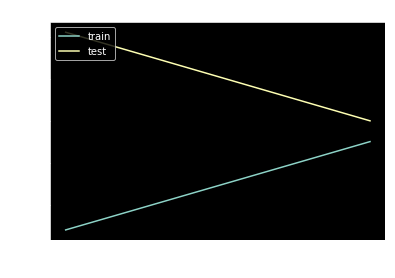

In [26]:

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


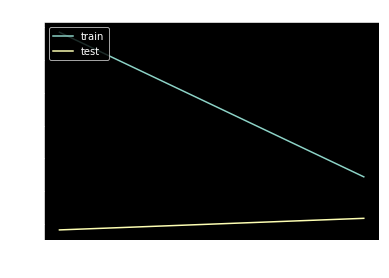

In [27]:


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()